In [11]:
import gymnasium as gym
import math
import random
from collections import namedtuple, deque
from itertools import count
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
from tqdm import tqdm
from torch.optim import Adam
from skimage.color import rgb2gray
from skimage.transform import resize
import matplotlib.pyplot as plt
from random import sample
from random import random

In [12]:
env = gym.make("ALE/Breakout-v5")
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
FIRE = 1

## Preprocessing

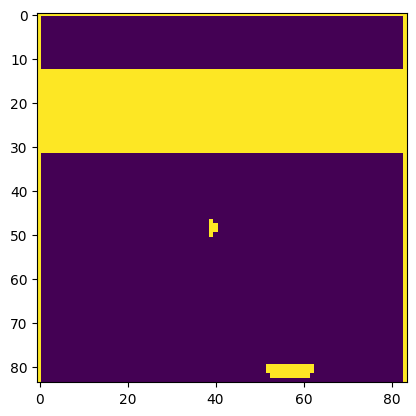

In [13]:
def pre_process(observe):
    processed_observe = np.uint8(resize(rgb2gray(observe)[31:-14,7:-7], (84, 84), mode='constant') * 255) > 0
    return processed_observe

state, info = env.reset()
obs, rwd, termin, trunc, info = env.step(FIRE)

plt.imshow(pre_process(obs))
plt.show()

## FF

In [14]:
class Net(torch.nn.Module):
    def __init__(self, dims):
        super().__init__()
        self.layers = []
        for d in range(len(dims) - 1):
            self.layers += [Layer(dims[d], dims[d + 1])]

    def predict(self, x):
        goodness_per_label = []
        for label in range(3):
            h = torch.tensor([x.tolist() + [label]], dtype=torch.float32)
            goodness = []
            for layer in self.layers:
                h = layer(h)
                goodness += [h.pow(2).mean(1)]
            goodness_per_label += [sum(goodness).unsqueeze(1)]
        goodness_per_label = torch.cat(goodness_per_label, 1)
        return goodness_per_label.argmax(1)

    def train(self, x_pos, x_neg):
        h_pos, h_neg = x_pos, x_neg
        for i, layer in enumerate(self.layers):
            print('training layer', i, '...')
            h_pos, h_neg = layer.train(h_pos, h_neg)

    def is_good(self, x):
        goodness = []
        h = x.clone().detach()
        for layer in self.layers:
            h = layer(h)
            goodness += [h.pow(2).mean(1)]
        return sum(goodness)

In [15]:
class Layer(nn.Linear):
    def __init__(self, in_features, out_features, bias=True, device=None, dtype=None):
        super().__init__(in_features, out_features, bias, device, dtype)
        self.relu = torch.nn.ReLU()
        self.opt = Adam(self.parameters(), lr=0.00003)
        self.threshold = 2.0
        self.num_epochs = 1

    def forward(self, x):
        x_direction = x / (x.norm(2, 1, keepdim=True) + 1e-4) # normalization
        # torch.mm -> matrix multiplication
        out = self.relu(torch.mm(x_direction, self.weight.T) + self.bias.unsqueeze(0))
        return out

    def train(self, x_pos, x_neg):
        for i in tqdm(range(self.num_epochs)):
            out_pos = self.forward(x_pos)
            out_neg = self.forward(x_neg)
            g_pos = out_pos.pow(2).mean(1)
            g_neg = out_neg.pow(2).mean(1)
            loss = torch.log(1 + torch.exp(torch.cat([g_pos - self.threshold, -g_neg + self.threshold]))).mean()
            self.opt.zero_grad()
            loss.backward()
            # torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=2)
            self.opt.step()
        return self.forward(x_pos).detach(), self.forward(x_neg).detach()

In [16]:
def hist_input(history):
    if history is not None:
        return torch.tensor(history > 0, dtype = torch.float, device=device)
    else:
        return history

def real_action(action):
    if action == 0:
        return 0
    elif action == 1:
        return 2
    else:
        return 3

def get_posneg_data(epsilon=0.5, N_neg=5):
    negative_data = []
    positive_data = []
    game_rwds = []
    for i_episode in range(4):
        state, info = env.reset()
        obs, rwd, termin, trunc, info = env.step(FIRE)
        history = np.stack((pre_process(obs), pre_process(obs), pre_process(obs), pre_process(obs)))
        history = np.expand_dims(history, axis = 0)
        game = []
        rwd_tot = 0
        for t in count():
            s = random()
            if s > epsilon:
                action = torch.randint(0, 3, size=(1,1))
            else:
                action = net.predict(torch.tensor(history.flatten())).item()
            obs, reward, terminated, truncated, new_info = env.step(real_action(action))
            rwd_tot += reward
            done = terminated or truncated
            if terminated:
                next_state = None
                game.append(history.flatten().tolist() + [action])
            else:
                next_state = pre_process(obs)
                next_state = np.reshape([next_state], (1, 1, 84, 84))
                next_history = np.append(next_state, history[:, :3, :, :], axis = 1)
                game.append(history.flatten().tolist() + [action])
            state = next_state
            if done:
                game_rwds.append(rwd_tot)
                if len(game) > N_neg and not truncated:
                    negative_data += game[-int(N_neg):]
                    positive_data += game[:-int(N_neg)]
                else:
                    negative_data += game
                break
            elif new_info['lives'] != info['lives']:
                # print(len(game))
                # print(len(game))
                game_rwds.append(rwd_tot)
                rwd_tot = 0
                if len(game) > N_neg and not truncated:
                    negative_data += game[-int(N_neg):]
                    positive_data += game[:-int(N_neg)]
                else:
                    negative_data += game

                obs, rwd, termin, trunc, info = env.step(FIRE)
                history = np.stack((pre_process(obs), pre_process(obs), pre_process(obs), pre_process(obs)))
                history = np.expand_dims(history, axis = 0)
                game = []
            else:
                info = new_info

    # print(len(game_rwds))
    mean_rwd=sum(game_rwds)/len(game_rwds)
    pos_len = len(positive_data)
    neg_len = len(negative_data)

    if pos_len > neg_len:
        positive_data = sample(positive_data, neg_len)
    else:
        negative_data = sample(negative_data, pos_len)

    return torch.tensor(positive_data, dtype=torch.float32), torch.tensor(negative_data, dtype=torch.float32), mean_rwd

In [17]:
net = Net([4*84*84+1, 300, 300])
env = gym.make("ALE/Breakout-v5")
n_iters = 3
mean_rwds = []

for i in range(n_iters):
    eps = 0.8*(1-i/n_iters)
    pos_data, neg_data, r = get_posneg_data(epsilon=eps, N_neg=15)
    mean_rwds.append(r)
    net.train(pos_data, neg_data)

training layer 0 ...


100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


training layer 1 ...


100%|██████████| 1/1 [00:00<00:00, 67.49it/s]


training layer 0 ...


100%|██████████| 1/1 [00:00<00:00,  2.01it/s]


training layer 1 ...


100%|██████████| 1/1 [00:00<00:00, 93.44it/s]


training layer 0 ...


100%|██████████| 1/1 [00:00<00:00,  1.82it/s]


training layer 1 ...


100%|██████████| 1/1 [00:00<00:00, 81.71it/s]


In [19]:
print(mean_rwds)
print(len(mean_rwds))

[0.5, 0.45, 0.2]
3


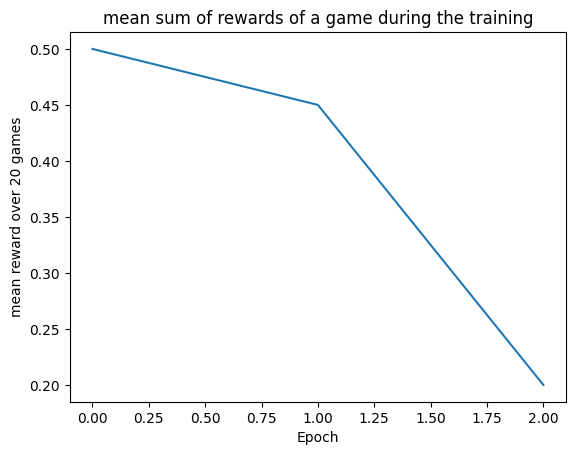

In [20]:
import matplotlib.pyplot as plt

plt.plot(mean_rwds)
plt.title("mean sum of rewards of a game during the training")
plt.xlabel("Epoch")
plt.ylabel("mean reward over 20 games")
plt.show()